## Hetereo Conv GNN

In [1]:
import torch
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
import networkx as nx
from torch_geometric.data import HeteroData

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Parameters
NUM_USERS = 500
NUM_IPS = 200
NUM_EMAILS = 500
NUM_SESSIONS = 300
NUM_ADDRESSES = 400
NUM_CLAIMS = 1000
FRAUD_RATE = 0.2  # 10% claims are fraudulent
EVENT_TYPES = ['signup', 'login', 'send_code', 'account_change']
MAX_EVENTS_PER_CLAIM = 10
BFS_DEPTH = 2  # Depth for BFS

# Helper functions
def generate_timestamp(base_time, delta_minutes=60):
    return base_time + timedelta(minutes=random.randint(0, delta_minutes))

# Generate variable pools
user_ids = [f"user_{i}" for i in range(NUM_USERS)]
# Designate a subset of IPs and sessions for fraud
fraud_ips = [f"ip_{i}" for i in range(10)]  # 10 IPs dedicated to fraud
normal_ips = [f"ip_{i}" for i in range(10, NUM_IPS)]
ips = fraud_ips + normal_ips

fraud_sessions = [f"session_{i}" for i in range(10)]  # 10 sessions for fraud
normal_sessions = [f"session_{i}" for i in range(10, NUM_SESSIONS)]
sessions = fraud_sessions + normal_sessions

emails = [f"user_{i}@example.com" for i in range(NUM_EMAILS)]
addresses = [f"address_{i}" for i in range(NUM_ADDRESSES)]

# Generate claims
base_time = datetime.now()
claims = []
for claim_id in range(NUM_CLAIMS):
    is_fraud = 1 if random.random() < FRAUD_RATE else 0
    num_events = random.randint(1, MAX_EVENTS_PER_CLAIM)
    claim_events = []
    claim_time = generate_timestamp(base_time, delta_minutes=1440)  # within a day
    
    for event_num in range(num_events):
        event_type = random.choice(EVENT_TYPES)
        # Adjust timestamp for velocity
        if is_fraud:
            # Faster velocities: smaller delta
            timestamp = claim_time + timedelta(minutes=random.randint(0, 10))
        else:
            # Normal velocities
            timestamp = claim_time + timedelta(minutes=random.randint(0, 60))
        
        event = {
            'event_id': f"claim_{claim_id}_event_{event_num}",
            'claim_id': f"claim_{claim_id}",
            'event_type': event_type,
            'timestamp': timestamp,
            'user_id': random.choice(user_ids),
            'ip': random.choice(fraud_ips) if is_fraud and random.random() < 0.7 else random.choice(normal_ips),
            'email': random.choice(emails),
            'session': random.choice(fraud_sessions) if is_fraud and random.random() < 0.7 else random.choice(normal_sessions),
            'address': random.choice(addresses),
            'is_fraud': is_fraud
        }
        claim_events.append(event)
    claims.append({
        'claim_id': f"claim_{claim_id}",
        'is_fraud': is_fraud,
        'events': claim_events
    })

# Flatten all events
all_events = []
for claim in claims:
    all_events.extend(claim['events'])

# Create DataFrame for easy processing
events_df = pd.DataFrame(all_events)

# Sort events by timestamp for velocity calculations
events_df = events_df.sort_values('timestamp').reset_index(drop=True)

# Compute count-based features
count_features = {
    'user_id': events_df['user_id'].value_counts().to_dict(),
    'ip': events_df['ip'].value_counts().to_dict(),
    'email': events_df['email'].value_counts().to_dict(),
    'session': events_df['session'].value_counts().to_dict(),
    'address': events_df['address'].value_counts().to_dict(),
    'event_type': events_df['event_type'].value_counts().to_dict()
}

# Compute velocity-based features
velocity_features = defaultdict(list)
last_event_time_user = {}
last_event_time_session = {}

for idx, row in events_df.iterrows():
    user = row['user_id']
    session = row['session']
    current_time = row['timestamp']
    
    # Velocity for user
    if user in last_event_time_user:
        delta = (current_time - last_event_time_user[user]).total_seconds() / 60.0  # minutes
        velocity_features['user_velocity'].append(delta)
    else:
        velocity_features['user_velocity'].append(0.0)
    last_event_time_user[user] = current_time
    
    # Velocity for session
    if session in last_event_time_session:
        delta = (current_time - last_event_time_session[session]).total_seconds() / 60.0  # minutes
        velocity_features['session_velocity'].append(delta)
    else:
        velocity_features['session_velocity'].append(0.0)
    last_event_time_session[session] = current_time

# Assign velocity features
events_df['user_velocity'] = velocity_features['user_velocity']
events_df['session_velocity'] = velocity_features['session_velocity']

# Additional suspicious indicators
# For fraud, increase the number of 'account_change' and 'login' events
events_df['num_account_changes'] = events_df.groupby('user_id')['event_type'].transform(
    lambda x: (x == 'account_change').cumsum()
)
events_df['num_failed_logins'] = events_df.groupby('user_id')['event_type'].transform(
    lambda x: (x == 'login').cumsum()
)

# Introduce higher counts for fraudulent claims
# Amplify counts for fraud
events_df.loc[events_df['is_fraud'] == 1, 'num_account_changes'] += random.randint(1, 5)
events_df.loc[events_df['is_fraud'] == 1, 'num_failed_logins'] += random.randint(1, 5)

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

le_event_type = LabelEncoder()
events_df['event_type_encoded'] = le_event_type.fit_transform(events_df['event_type'])

# Prepare HeteroData
data = HeteroData()

# Create node indices
event_ids = events_df['event_id'].unique()
user_id_ids = events_df['user_id'].unique()
ip_ids = events_df['ip'].unique()
email_ids = events_df['email'].unique()
session_ids = events_df['session'].unique()
address_ids = events_df['address'].unique()

# Mapping from ID to index
event_id_map = {eid: idx for idx, eid in enumerate(event_ids)}
user_id_map = {uid: idx for idx, uid in enumerate(user_id_ids)}
ip_map = {ip: idx for idx, ip in enumerate(ip_ids)}
email_map = {email: idx for idx, email in enumerate(email_ids)}
session_map = {sess: idx for idx, sess in enumerate(session_ids)}
address_map = {addr: idx for idx, addr in enumerate(address_ids)}

# Add event nodes with features
num_events = len(event_ids)
data['event'].num_nodes = num_events

# Features for event nodes
# Example features: event_type_encoded, user_velocity, session_velocity, num_account_changes, num_failed_logins
event_features = torch.tensor(
    events_df[['event_type_encoded', 'user_velocity', 'session_velocity', 'num_account_changes', 'num_failed_logins']].values,
    dtype=torch.float
)
data['event'].x = event_features

# Add other node types with dummy features (e.g., one-hot encoded)
# For simplicity, we'll use identity features
data['user_id'].num_nodes = len(user_id_ids)
data['user_id'].x = torch.eye(len(user_id_ids), dtype=torch.float)

data['ip'].num_nodes = len(ip_ids)
data['ip'].x = torch.eye(len(ip_ids), dtype=torch.float)

data['email'].num_nodes = len(email_ids)
data['email'].x = torch.eye(len(email_ids), dtype=torch.float)

data['session'].num_nodes = len(session_ids)
data['session'].x = torch.eye(len(session_ids), dtype=torch.float)

data['address'].num_nodes = len(address_ids)
data['address'].x = torch.eye(len(address_ids), dtype=torch.float)

# Create edge connections
# Define edge types: event to variable and variable to event (bidirectional)
edge_index_dict = {}

# event -> user_id
source = events_df['event_id'].map(event_id_map).values
target = events_df['user_id'].map(user_id_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_user_id', 'user_id')] = edge_index

# user_id -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('user_id', 'user_id_has', 'event')] = edge_index_rev

# event -> ip
source = events_df['event_id'].map(event_id_map).values
target = events_df['ip'].map(ip_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_ip', 'ip')] = edge_index

# ip -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('ip', 'ip_has', 'event')] = edge_index_rev

# event -> email
source = events_df['event_id'].map(event_id_map).values
target = events_df['email'].map(email_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_email', 'email')] = edge_index

# email -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('email', 'email_has', 'event')] = edge_index_rev

# event -> session
source = events_df['event_id'].map(event_id_map).values
target = events_df['session'].map(session_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_session', 'session')] = edge_index

# session -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('session', 'session_has', 'event')] = edge_index_rev

# event -> address
source = events_df['event_id'].map(event_id_map).values
target = events_df['address'].map(address_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_address', 'address')] = edge_index

# address -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('address', 'address_has', 'event')] = edge_index_rev

# Assign all edge indices to data
for key, edge in edge_index_dict.items():
    data[key[0], key[1], key[2]].edge_index = edge

# Create label for each claim
claim_labels = torch.tensor([claim['is_fraud'] for claim in claims], dtype=torch.long)

# Map claim_id to event_ids
claim_to_event = defaultdict(list)
for idx, row in events_df.iterrows():
    claim_to_event[row['claim_id']].append(event_id_map[row['event_id']])

# Assign label to all events of each claim
event_labels = torch.zeros(num_events, dtype=torch.long)
for claim_idx, claim in enumerate(claims):
    fraud_label = claim['is_fraud']
    for event_id in claim_to_event[claim['claim_id']]:
        event_labels[event_id] = fraud_label

data['event'].y = event_labels

# Save the data (optional)
# torch.save(data, 'fraud_detection_data_with_signals.pt')

print("Graph data generation with fraud signals completed.")
print(f"Number of event nodes: {data['event'].num_nodes}")
for node_type in data.node_types:
    print(f"Node type '{node_type}': {data[node_type].num_nodes} nodes")


Graph data generation with fraud signals completed.
Number of event nodes: 5508
Node type 'event': 5508 nodes
Node type 'user_id': 500 nodes
Node type 'ip': 200 nodes
Node type 'email': 500 nodes
Node type 'session': 300 nodes
Node type 'address': 400 nodes


C:\Users\nyihm\AppData\Local\Temp\ipykernel_186444\2134188108.py:209: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index = torch.tensor([source, target], dtype=torch.long)


In [2]:
data

HeteroData(
  event={
    num_nodes=5508,
    x=[5508, 5],
    y=[5508],
  },
  user_id={
    num_nodes=500,
    x=[500, 500],
  },
  ip={
    num_nodes=200,
    x=[200, 200],
  },
  email={
    num_nodes=500,
    x=[500, 500],
  },
  session={
    num_nodes=300,
    x=[300, 300],
  },
  address={
    num_nodes=400,
    x=[400, 400],
  },
  (event, has_user_id, user_id)={ edge_index=[2, 5508] },
  (user_id, user_id_has, event)={ edge_index=[2, 5508] },
  (event, has_ip, ip)={ edge_index=[2, 5508] },
  (ip, ip_has, event)={ edge_index=[2, 5508] },
  (event, has_email, email)={ edge_index=[2, 5508] },
  (email, email_has, event)={ edge_index=[2, 5508] },
  (event, has_session, session)={ edge_index=[2, 5508] },
  (session, session_has, event)={ edge_index=[2, 5508] },
  (event, has_address, address)={ edge_index=[2, 5508] },
  (address, address_has, event)={ edge_index=[2, 5508] }
)

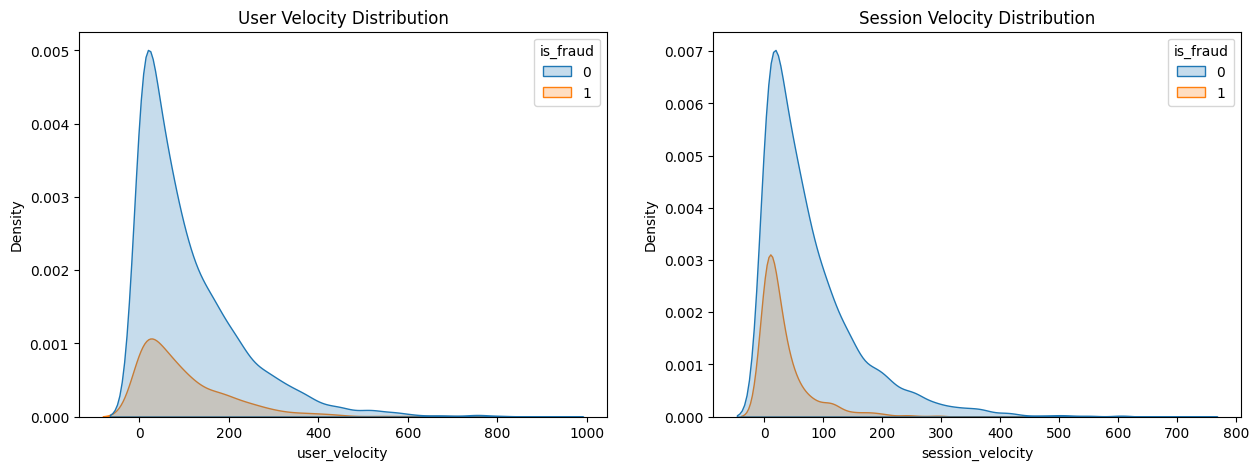

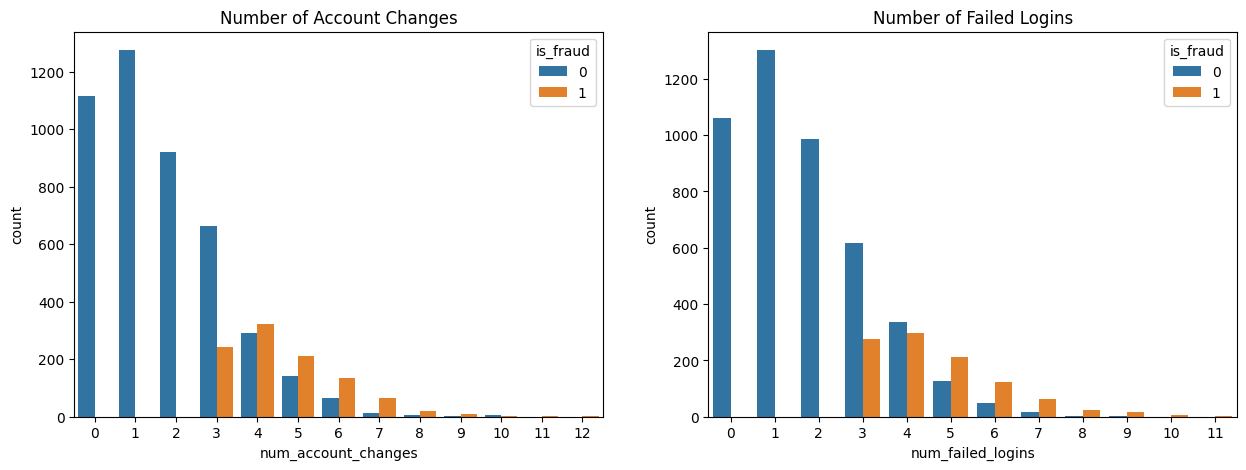

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert event labels to DataFrame
events_df['is_fraud'] = data['event'].y.numpy()

# Visualize distributions of key features
plt.figure(figsize=(15, 5))

# Velocity comparison
plt.subplot(1, 2, 1)
sns.kdeplot(data=events_df, x='user_velocity', hue='is_fraud', fill=True)
plt.title('User Velocity Distribution')

plt.subplot(1, 2, 2)
sns.kdeplot(data=events_df, x='session_velocity', hue='is_fraud', fill=True)
plt.title('Session Velocity Distribution')

plt.show()

# Count-based features comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=events_df, x='num_account_changes', hue='is_fraud')
plt.title('Number of Account Changes')

plt.subplot(1, 2, 2)
sns.countplot(data=events_df, x='num_failed_logins', hue='is_fraud')
plt.title('Number of Failed Logins')

plt.show()


In [9]:
# Block 2: Build the GNN Model Using Message Passing for Fraud Classification

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import HeteroConv, SAGEConv
from torch_geometric.data import HeteroData
from sklearn.metrics import accuracy_score, f1_score

# Assume data is already loaded from Block 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Calculate class weights
labels = data['event'].y
class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalize weights
class_weights = class_weights.to(device)

# Define the GNN model
class FraudDetectionGNN(nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: SAGEConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.conv2 = HeteroConv({
            edge_type: SAGEConv((-1, hidden_channels), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        # Linear layer for classification
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        # First layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        # Second layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # For event nodes, get their embeddings
        event_embeddings = x_dict['event']

        # Classification
        out = self.lin(event_embeddings)
        return out

# Initialize the model
hidden_channels = 64
out_channels = 2  # Fraudulent or not
model = FraudDetectionGNN(hidden_channels, out_channels, data.metadata()).to(device)

# Define optimizer and loss with class weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Prepare data for training
num_events = data['event'].num_nodes
mask = torch.rand(num_events, device=device) < 0.8  # 80% train, 20% test
train_mask = mask
test_mask = ~mask

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out[train_mask], data['event'].y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def test():
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data['event'].y[train_mask].cpu(), pred[train_mask].cpu())
    test_acc = accuracy_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    test_f1 = f1_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    return train_acc, test_acc, test_f1

# Training the model
for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        train_acc, test_acc, test_f1 = test()
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

print("Training completed.")


Epoch: 010, Loss: 3.0242, Train Acc: 0.8446, Test Acc: 0.8392, Test F1: 0.3218
Epoch: 020, Loss: 0.9673, Train Acc: 0.7179, Test Acc: 0.7121, Test F1: 0.5247
Epoch: 030, Loss: 0.4230, Train Acc: 0.7840, Test Acc: 0.7929, Test F1: 0.6225
Epoch: 040, Loss: 0.2693, Train Acc: 0.9192, Test Acc: 0.9292, Test F1: 0.8211
Epoch: 050, Loss: 0.1591, Train Acc: 0.9621, Test Acc: 0.9637, Test F1: 0.9024
Epoch: 060, Loss: 0.1208, Train Acc: 0.9651, Test Acc: 0.9664, Test F1: 0.9129
Epoch: 070, Loss: 0.1052, Train Acc: 0.9646, Test Acc: 0.9655, Test F1: 0.9128
Epoch: 080, Loss: 0.0939, Train Acc: 0.9696, Test Acc: 0.9700, Test F1: 0.9224
Epoch: 090, Loss: 0.0882, Train Acc: 0.9676, Test Acc: 0.9646, Test F1: 0.9108
Epoch: 100, Loss: 0.0817, Train Acc: 0.9682, Test Acc: 0.9646, Test F1: 0.9108
Training completed.


Label Distribution: {0: 4493, 1: 1015}


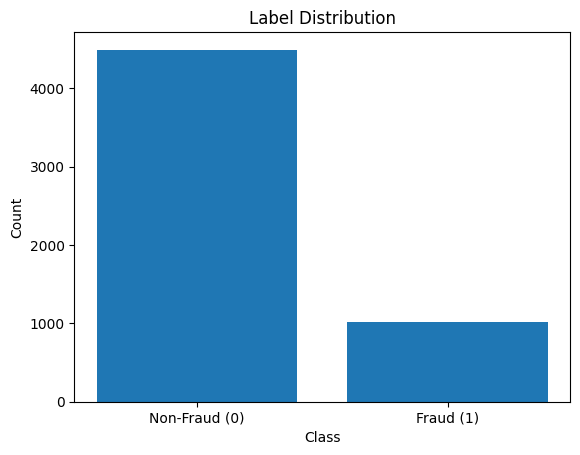

In [6]:
# After Block 1: Data Generation with Fraud Signals

# Calculate label distribution
labels = data['event'].y.cpu().numpy()
unique, counts = np.unique(labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
print(f"Label Distribution: {label_distribution}")

# Visualize label distribution
import matplotlib.pyplot as plt

plt.bar(['Non-Fraud (0)', 'Fraud (1)'], [label_distribution.get(0, 0), label_distribution.get(1, 0)])
plt.title('Label Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


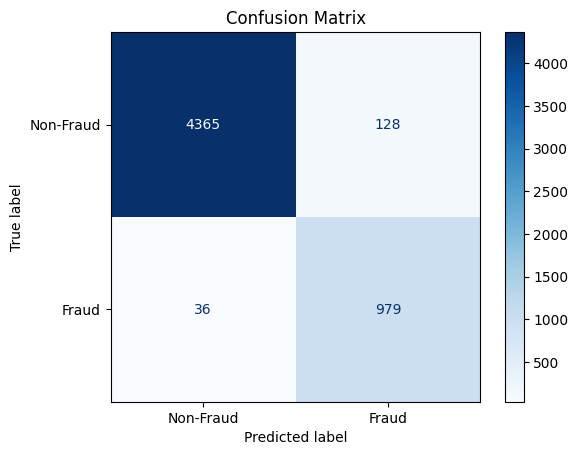

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After training loop

# Final predictions
model.eval()
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1).cpu().numpy()
    labels = data['event'].y.cpu().numpy()

# Confusion Matrix
cm = confusion_matrix(labels, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


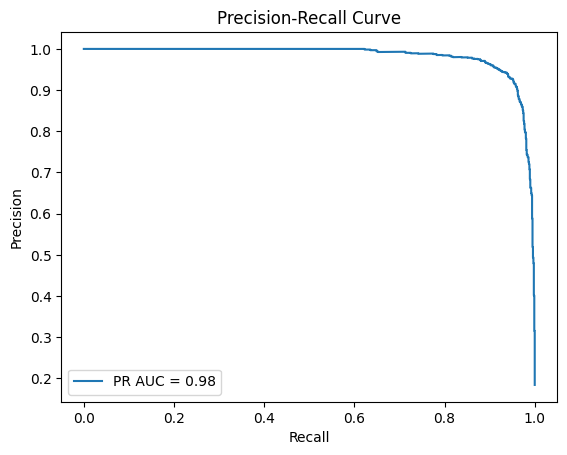

In [8]:
from sklearn.metrics import precision_recall_curve, auc

# Compute probabilities
with torch.no_grad():
    probabilities = F.softmax(out, dim=1)[:, 1].cpu().numpy()

precision, recall, _ = precision_recall_curve(labels, probabilities)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


## 2

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import (
    HeteroConv, GCNConv, GATConv, SAGEConv, GINConv, RGCNConv
)
from torch_geometric.data import HeteroData
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


In [12]:
class BaseGNN(nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super(BaseGNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.metadata = metadata

    def forward(self, x_dict, edge_index_dict):
        raise NotImplementedError("Each GNN model must implement the forward method.")
    
class HeteroGCN(BaseGNN):
    def __init__(self, hidden_channels, out_channels, metadata):
        super(HeteroGCN, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: GCNConv((-1, -1), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.conv2 = HeteroConv({
            edge_type: GCNConv((-1, hidden_channels), hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out
    
class HeteroGAT(BaseGNN):
    def __init__(self, hidden_channels, out_channels, metadata, heads=4):
        super(HeteroGAT, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: GATConv((-1, -1), hidden_channels // heads, heads=heads, concat=True)
            for edge_type in metadata[1]
        }, aggr='mean')

        self.conv2 = HeteroConv({
            edge_type: GATConv((-1, hidden_channels), hidden_channels, heads=1, concat=False)
            for edge_type in metadata[1]
        }, aggr='mean')

        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.elu(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.elu(x) for key, x in x_dict.items()}
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out
    
class HeteroGIN(BaseGNN):
    def __init__(self, hidden_channels, out_channels, metadata):
        super(HeteroGIN, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: GINConv(
                nn.Sequential(
                    nn.Linear(-1, hidden_channels),
                    nn.ReLU(),
                    nn.Linear(hidden_channels, hidden_channels)
                )
            )
            for edge_type in metadata[1]
        }, aggr='sum')

        self.conv2 = HeteroConv({
            edge_type: GINConv(
                nn.Sequential(
                    nn.Linear(-1, hidden_channels),
                    nn.ReLU(),
                    nn.Linear(hidden_channels, hidden_channels)
                )
            )
            for edge_type in metadata[1]
        }, aggr='sum')

        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out
    
class HeteroRGCN(BaseGNN):
    def __init__(self, hidden_channels, out_channels, metadata, num_relations):
        super(HeteroRGCN, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: RGCNConv((-1, -1), hidden_channels, num_relations)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.conv2 = HeteroConv({
            edge_type: RGCNConv((-1, hidden_channels), hidden_channels, num_relations)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out
    
# Define available models
model_dict = {
    'HeteroGCN': HeteroGCN,
    'HeteroGAT': HeteroGAT,
    'HeteroGIN': HeteroGIN,
    'HeteroRGCN': HeteroRGCN
}


In [13]:
# Assuming `data` is your HeteroData object loaded from Block 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Re-assign labels to all events of each claim if not done already
claim_to_event = defaultdict(list)
for idx, row in events_df.iterrows():
    claim_to_event[row['claim_id']].append(event_id_map[row['event_id']])

event_labels = torch.zeros(data['event'].num_nodes, dtype=torch.long)
for claim in claims:
    fraud_label = claim['is_fraud']
    for event_id in claim_to_event[claim['claim_id']]:
        event_labels[event_id] = fraud_label

data['event'].y = event_labels.to(device)

# Calculate class weights
labels = data['event'].y
class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalize weights
class_weights = class_weights.to(device)


In [14]:
def train_model(model, data, optimizer, criterion, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out[train_mask], data['event'].y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate_model(model, data, train_mask, test_mask):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)

    train_acc = accuracy_score(data['event'].y[train_mask].cpu(), pred[train_mask].cpu())
    test_acc = accuracy_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    test_f1 = f1_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())

    return train_acc, test_acc, test_f1


In [15]:
def train_and_evaluate(model_name, model_class, data, num_relations=None, epochs=100, hidden_channels=128, lr=0.005, weight_decay=5e-4, patience=10):
    print(f"\nTraining {model_name}...")

    if model_name == 'HeteroRGCN':
        model = model_class(hidden_channels, out_channels=2, metadata=data.metadata(), num_relations=len(data.edge_types)).to(device)
    else:
        model = model_class(hidden_channels, out_channels=2, metadata=data.metadata()).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Split data
    num_events = data['event'].num_nodes
    mask = torch.rand(num_events, device=device) < 0.8  # 80% train, 20% test
    train_mask = mask
    test_mask = ~mask

    # Initialize early stopping parameters
    best_test_f1 = 0
    trigger_times = 0

    history = {'loss': [], 'train_acc': [], 'test_acc': [], 'test_f1': []}

    for epoch in range(1, epochs + 1):
        loss = train_model(model, data, optimizer, criterion, train_mask)
        history['loss'].append(loss)

        train_acc, test_acc, test_f1 = evaluate_model(model, data, train_mask, test_mask)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(test_f1)

        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")

        # Early Stopping Check
        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
            trigger_times = 0
            best_model_state = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # Load best model state
    model.load_state_dict(best_model_state)

    # Final evaluation
    final_train_acc, final_test_acc, final_test_f1 = evaluate_model(model, data, train_mask, test_mask)
    print(f"Best Test F1: {best_test_f1:.4f} | Final Test F1: {final_test_f1:.4f}")

    return model, history, (train_mask, test_mask)


In [16]:
# Train HeteroGCN
hetero_gcn, history_gcn, masks_gcn = train_and_evaluate(
    model_name='HeteroGCN',
    model_class=HeteroGCN,
    data=data,
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)



Training HeteroGCN...


TypeError: '>' not supported between instances of 'tuple' and 'int'

In [17]:
# Train HeteroGAT
hetero_gat, history_gat, masks_gat = train_and_evaluate(
    model_name='HeteroGAT',
    model_class=HeteroGAT,
    data=data,
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)



Training HeteroGAT...


ValueError: 'add_self_loops' attribute set to 'True' on module 'GATConv((-1, -1), 32, heads=4)' for use with edge type(s) '[('event', 'has_user_id', 'user_id')]'. This will lead to incorrect message passing results.

In [18]:
# Train HeteroGIN
hetero_gin, history_gin, masks_gin = train_and_evaluate(
    model_name='HeteroGIN',
    model_class=HeteroGIN,
    data=data,
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)



Training HeteroGIN...


RuntimeError: Trying to create tensor with negative dimension -1: [128, -1]

In [19]:
# Train HeteroRGCN
hetero_rgcn, history_rgcn, masks_rgcn = train_and_evaluate(
    model_name='HeteroRGCN',
    model_class=HeteroRGCN,
    data=data,
    num_relations=len(data.edge_types),
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)



Training HeteroRGCN...


RuntimeError: Trying to create tensor with negative dimension -1: [10, -1, 128]

In [20]:
# Collect F1 scores
results = {
    'HeteroGCN': history_gcn['test_f1'][-1],
    'HeteroGAT': history_gat['test_f1'][-1],
    'HeteroGIN': history_gin['test_f1'][-1],
    'HeteroRGCN': history_rgcn['test_f1'][-1]
}

# Display results
for model_name, f1 in results.items():
    print(f"{model_name}: Test F1 Score = {f1:.4f}")


NameError: name 'history_gcn' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for model_name, history in zip(['HeteroGCN', 'HeteroGAT', 'HeteroGIN', 'HeteroRGCN'],
                               [history_gcn, history_gat, history_gin, history_rgcn]):
    plt.plot(history['test_f1'], label=model_name)

plt.xlabel('Epoch')
plt.ylabel('Test F1 Score')
plt.title('Test F1 Score Over Epochs for Different GNN Models')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score

def get_detailed_metrics(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        pred = out.argmax(dim=1).cpu().numpy()
        labels = data['event'].y[mask].cpu().numpy()
        precision = precision_score(labels, pred[mask.cpu()], zero_division=0)
        recall = recall_score(labels, pred[mask.cpu()], zero_division=0)
        accuracy = accuracy_score(labels, pred[mask.cpu()])
        f1 = f1_score(labels, pred[mask.cpu()], zero_division=0)
    return precision, recall, accuracy, f1

# Collect detailed metrics
detailed_results = {}

for model_name, model, history, masks in zip(
    ['HeteroGCN', 'HeteroGAT', 'HeteroGIN', 'HeteroRGCN'],
    [hetero_gcn, hetero_gat, hetero_gin, hetero_rgcn],
    [history_gcn, history_gat, history_gin, history_rgcn],
    [masks_gcn, masks_gat, masks_gin, masks_rgcn]
):
    precision, recall, accuracy, f1 = get_detailed_metrics(model, data, masks[1])
    detailed_results[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1
    }

# Display detailed results
import pandas as pd

df_results = pd.DataFrame(detailed_results).T
print(df_results)


In [24]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from collections import defaultdict
from torch_geometric.data import HeteroData
from torch_geometric.nn import (
    HeteroConv,
    GCNConv,
    GATConv,
    SAGEConv,
    GINConv,
    RGCNConv,
    GraphConv
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ============================
# Block 1: Data Generation with Fraud Signals
# ============================

# Parameters
NUM_USERS = 500
NUM_IPS = 200
NUM_EMAILS = 500
NUM_SESSIONS = 300
NUM_ADDRESSES = 400
NUM_CLAIMS = 1000
FRAUD_RATE = 0.4  # 40% claims are fraudulent
EVENT_TYPES = ['signup', 'login', 'send_code', 'account_change']
MAX_EVENTS_PER_CLAIM = 10
BFS_DEPTH = 2  # Depth for BFS

# Helper functions
def generate_timestamp(base_time, delta_minutes=60):
    return base_time + timedelta(minutes=random.randint(0, delta_minutes))

# Generate variable pools
user_ids = [f"user_{i}" for i in range(NUM_USERS)]
# Designate a subset of IPs and sessions for fraud
fraud_ips = [f"ip_{i}" for i in range(10)]  # 10 IPs dedicated to fraud
normal_ips = [f"ip_{i}" for i in range(10, NUM_IPS)]
ips = fraud_ips + normal_ips

fraud_sessions = [f"session_{i}" for i in range(10)]  # 10 sessions for fraud
normal_sessions = [f"session_{i}" for i in range(10, NUM_SESSIONS)]
sessions = fraud_sessions + normal_sessions

emails = [f"user_{i}@example.com" for i in range(NUM_EMAILS)]
addresses = [f"address_{i}" for i in range(NUM_ADDRESSES)]

# Generate claims
base_time = datetime.now()
claims = []
for claim_id in range(NUM_CLAIMS):
    is_fraud = 1 if random.random() < FRAUD_RATE else 0
    num_events = random.randint(1, MAX_EVENTS_PER_CLAIM)
    claim_events = []
    claim_time = generate_timestamp(base_time, delta_minutes=1440)  # within a day
    
    for event_num in range(num_events):
        event_type = random.choice(EVENT_TYPES)
        # Adjust timestamp for velocity
        if is_fraud:
            # Faster velocities: smaller delta
            timestamp = claim_time + timedelta(minutes=random.randint(0, 10))
        else:
            # Normal velocities
            timestamp = claim_time + timedelta(minutes=random.randint(0, 60))
        
        event = {
            'event_id': f"claim_{claim_id}_event_{event_num}",
            'claim_id': f"claim_{claim_id}",
            'event_type': event_type,
            'timestamp': timestamp,
            'user_id': random.choice(user_ids),
            'ip': random.choice(fraud_ips) if is_fraud and random.random() < 0.7 else random.choice(normal_ips),
            'email': random.choice(emails),
            'session': random.choice(fraud_sessions) if is_fraud and random.random() < 0.7 else random.choice(normal_sessions),
            'address': random.choice(addresses),
            'is_fraud': is_fraud
        }
        claim_events.append(event)
    claims.append({
        'claim_id': f"claim_{claim_id}",
        'is_fraud': is_fraud,
        'events': claim_events
    })

# Flatten all events
all_events = []
for claim in claims:
    all_events.extend(claim['events'])

# Create DataFrame for easy processing
events_df = pd.DataFrame(all_events)

# Sort events by timestamp for velocity calculations
events_df = events_df.sort_values('timestamp').reset_index(drop=True)

# Compute count-based features
count_features = {
    'user_id': events_df['user_id'].value_counts().to_dict(),
    'ip': events_df['ip'].value_counts().to_dict(),
    'email': events_df['email'].value_counts().to_dict(),
    'session': events_df['session'].value_counts().to_dict(),
    'address': events_df['address'].value_counts().to_dict(),
    'event_type': events_df['event_type'].value_counts().to_dict()
}

# Compute velocity-based features
velocity_features = defaultdict(list)
last_event_time_user = {}
last_event_time_session = {}

for idx, row in events_df.iterrows():
    user = row['user_id']
    session = row['session']
    current_time = row['timestamp']
    
    # Velocity for user
    if user in last_event_time_user:
        delta = (current_time - last_event_time_user[user]).total_seconds() / 60.0  # minutes
        velocity_features['user_velocity'].append(delta)
    else:
        velocity_features['user_velocity'].append(0.0)
    last_event_time_user[user] = current_time
    
    # Velocity for session
    if session in last_event_time_session:
        delta = (current_time - last_event_time_session[session]).total_seconds() / 60.0  # minutes
        velocity_features['session_velocity'].append(delta)
    else:
        velocity_features['session_velocity'].append(0.0)
    last_event_time_session[session] = current_time

# Assign velocity features
events_df['user_velocity'] = velocity_features['user_velocity']
events_df['session_velocity'] = velocity_features['session_velocity']

# Additional suspicious indicators
# For fraud, increase the number of 'account_change' and 'login' events
events_df['num_account_changes'] = events_df.groupby('user_id')['event_type'].transform(
    lambda x: (x == 'account_change').cumsum()
)
events_df['num_failed_logins'] = events_df.groupby('user_id')['event_type'].transform(
    lambda x: (x == 'login').cumsum()
)

# Introduce higher counts for fraudulent claims
# Amplify counts for fraud
fraud_indices = events_df['is_fraud'] == 1
# To avoid randomness in counts, use a fixed increment based on fraud
events_df.loc[fraud_indices, 'num_account_changes'] += 3  # Fixed increment for simplicity
events_df.loc[fraud_indices, 'num_failed_logins'] += 3

# Encode categorical variables
le_event_type = LabelEncoder()
events_df['event_type_encoded'] = le_event_type.fit_transform(events_df['event_type'])

# Normalize continuous features
scaler = StandardScaler()
continuous_features = ['user_velocity', 'session_velocity', 'num_account_changes', 'num_failed_logins']
events_df[continuous_features] = scaler.fit_transform(events_df[continuous_features])

# Prepare HeteroData
data = HeteroData()

# Create node indices
event_ids = events_df['event_id'].unique()
user_id_ids = events_df['user_id'].unique()
ip_ids = events_df['ip'].unique()
email_ids = events_df['email'].unique()
session_ids = events_df['session'].unique()
address_ids = events_df['address'].unique()

# Mapping from ID to index
event_id_map = {eid: idx for idx, eid in enumerate(event_ids)}
user_id_map = {uid: idx for idx, uid in enumerate(user_id_ids)}
ip_map = {ip: idx for idx, ip in enumerate(ip_ids)}
email_map = {email: idx for idx, email in enumerate(email_ids)}
session_map = {sess: idx for sess, sess_idx in zip(session_ids, range(len(session_ids)))}
address_map = {addr: idx for addr, addr_idx in zip(address_ids, range(len(address_ids)))}

# Add event nodes with features
num_events = len(event_ids)
data['event'].num_nodes = num_events

# Features for event nodes
# event_type_encoded, user_velocity, session_velocity, num_account_changes, num_failed_logins
event_features = torch.tensor(
    events_df[['event_type_encoded', 'user_velocity', 'session_velocity', 'num_account_changes', 'num_failed_logins']].values,
    dtype=torch.float
)
data['event'].x = event_features

# Add other node types with one-hot encoded features
# To reduce dimensionality, project one-hot to embeddings later
data['user_id'].num_nodes = len(user_id_ids)
data['user_id'].x = torch.eye(len(user_id_ids), dtype=torch.float)

data['ip'].num_nodes = len(ip_ids)
data['ip'].x = torch.eye(len(ip_ids), dtype=torch.float)

data['email'].num_nodes = len(email_ids)
data['email'].x = torch.eye(len(email_ids), dtype=torch.float)

data['session'].num_nodes = len(session_ids)
data['session'].x = torch.eye(len(session_ids), dtype=torch.float)

data['address'].num_nodes = len(address_ids)
data['address'].x = torch.eye(len(address_ids), dtype=torch.float)

# Create edge connections
# Define edge types: event to variable and variable to event (bidirectional)
edge_index_dict = {}

# event -> user_id
source = events_df['event_id'].map(event_id_map).values
target = events_df['user_id'].map(user_id_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_user_id', 'user_id')] = edge_index

# user_id -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('user_id', 'user_id_has', 'event')] = edge_index_rev

# event -> ip
source = events_df['event_id'].map(event_id_map).values
target = events_df['ip'].map(ip_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_ip', 'ip')] = edge_index

# ip -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('ip', 'ip_has', 'event')] = edge_index_rev

# event -> email
source = events_df['event_id'].map(event_id_map).values
target = events_df['email'].map(email_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_email', 'email')] = edge_index

# email -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('email', 'email_has', 'event')] = edge_index_rev

# event -> session
source = events_df['event_id'].map(event_id_map).values
target = events_df['session'].map(session_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_session', 'session')] = edge_index

# session -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('session', 'session_has', 'event')] = edge_index_rev

# event -> address
source = events_df['event_id'].map(event_id_map).values
target = events_df['address'].map(address_map).values
edge_index = torch.tensor([source, target], dtype=torch.long)
edge_index_dict[('event', 'has_address', 'address')] = edge_index

# address -> event
edge_index_rev = torch.tensor([target, source], dtype=torch.long)
edge_index_dict[('address', 'address_has', 'event')] = edge_index_rev

# Assign all edge indices to data
for key, edge in edge_index_dict.items():
    data[key[0], key[1], key[2]].edge_index = edge

# Create label for each claim
claim_labels = torch.tensor([claim['is_fraud'] for claim in claims], dtype=torch.long)

# Map claim_id to event_ids
claim_to_event = defaultdict(list)
for idx, row in events_df.iterrows():
    claim_to_event[row['claim_id']].append(event_id_map[row['event_id']])

# Assign label to all events of each claim
event_labels = torch.zeros(num_events, dtype=torch.long)
for claim in claims:
    fraud_label = claim['is_fraud']
    for event_id in claim_to_event[claim['claim_id']]:
        event_labels[event_id] = fraud_label

data['event'].y = event_labels  # Label only event nodes (claims)

# Normalize other node features if necessary (already done for event nodes)

# Move data to CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

print("Graph data generation with fraud signals completed.")
print(f"Number of event nodes: {data['event'].num_nodes}")
for node_type in data.node_types:
    print(f"Node type '{node_type}': {data[node_type].num_nodes} nodes")

# ============================
# Block 2: GNN Model Definitions, Training, and Evaluation
# ============================

# Define multiple GNN models with correct handling of heterogeneous data
class BaseHeteroGNN(nn.Module):
    def __init__(self, hidden_channels, out_channels, metadata):
        super(BaseHeteroGNN, self).__init__()
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.metadata = metadata

        # Define initial embedding layers for each node type
        self.embeddings = nn.ModuleDict()
        for node_type in metadata[0]:
            in_channels = data[node_type].x.shape[1]
            self.embeddings[node_type] = nn.Linear(in_channels, hidden_channels)
    
    def forward(self, x_dict, edge_index_dict):
        # Apply embeddings
        for node_type, embedding in self.embeddings.items():
            x_dict[node_type] = embedding(x_dict[node_type])
            x_dict[node_type] = F.relu(x_dict[node_type])
        return x_dict

# Define HeteroGCN
class HeteroGCN(BaseHeteroGNN):
    def __init__(self, hidden_channels, out_channels, metadata):
        super(HeteroGCN, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: GraphConv(hidden_channels, hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')
        
        self.conv2 = HeteroConv({
            edge_type: GraphConv(hidden_channels, hidden_channels)
            for edge_type in metadata[1]
        }, aggr='sum')
        
        self.lin = nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        x_dict = super().forward(x_dict, edge_index_dict)
        
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out

# Define HeteroGAT
class HeteroGAT(BaseHeteroGNN):
    def __init__(self, hidden_channels, out_channels, metadata, heads=4):
        super(HeteroGAT, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: GATConv(hidden_channels, hidden_channels // heads, heads=heads, concat=True, add_self_loops=False)
            for edge_type in metadata[1]
        }, aggr='mean')
        
        self.conv2 = HeteroConv({
            edge_type: GATConv(hidden_channels, hidden_channels // heads, heads=heads, concat=True, add_self_loops=False)
            for edge_type in metadata[1]
        }, aggr='mean')
        
        self.lin = nn.Linear(hidden_channels * heads, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        x_dict = super().forward(x_dict, edge_index_dict)
        
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.elu(x) for key, x in x_dict.items()}
        
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.elu(x) for key, x in x_dict.items()}
        
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out

# Define HeteroGIN
class HeteroGIN(BaseHeteroGNN):
    def __init__(self, hidden_channels, out_channels, metadata):
        super(HeteroGIN, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: GINConv(
                nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    nn.ReLU(),
                    nn.Linear(hidden_channels, hidden_channels)
                )
            )
            for edge_type in metadata[1]
        }, aggr='sum')
        
        self.conv2 = HeteroConv({
            edge_type: GINConv(
                nn.Sequential(
                    nn.Linear(hidden_channels, hidden_channels),
                    nn.ReLU(),
                    nn.Linear(hidden_channels, hidden_channels)
                )
            )
            for edge_type in metadata[1]
        }, aggr='sum')
        
        self.lin = nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        x_dict = super().forward(x_dict, edge_index_dict)
        
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out

# Define HeteroRGCN
class HeteroRGCN(BaseHeteroGNN):
    def __init__(self, hidden_channels, out_channels, metadata, num_relations):
        super(HeteroRGCN, self).__init__(hidden_channels, out_channels, metadata)
        self.conv1 = HeteroConv({
            edge_type: RGCNConv(hidden_channels, hidden_channels, num_relations)
            for edge_type in metadata[1]
        }, aggr='sum')
        
        self.conv2 = HeteroConv({
            edge_type: RGCNConv(hidden_channels, hidden_channels, num_relations)
            for edge_type in metadata[1]
        }, aggr='sum')
        
        self.lin = nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x_dict, edge_index_dict):
        x_dict = super().forward(x_dict, edge_index_dict)
        
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        
        event_embeddings = x_dict['event']
        out = self.lin(event_embeddings)
        return out

# Define available models
model_dict = {
    'HeteroGCN': HeteroGCN,
    'HeteroGAT': HeteroGAT,
    'HeteroGIN': HeteroGIN,
    'HeteroRGCN': HeteroRGCN
}

# Calculate class weights
labels = data['event'].y
class_counts = torch.bincount(labels)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalize weights
class_weights = class_weights.to(device)
print(f"Class Weights: {class_weights}")

# Define training and evaluation functions
def train_model(model, data, optimizer, criterion, train_mask):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = criterion(out[train_mask], data['event'].y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def evaluate_model(model, data, train_mask, test_mask):
    model.eval()
    out = model(data.x_dict, data.edge_index_dict)
    pred = out.argmax(dim=1)
    
    train_acc = accuracy_score(data['event'].y[train_mask].cpu(), pred[train_mask].cpu())
    test_acc = accuracy_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    test_f1 = f1_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu())
    test_precision = precision_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu(), zero_division=0)
    test_recall = recall_score(data['event'].y[test_mask].cpu(), pred[test_mask].cpu(), zero_division=0)
    
    return train_acc, test_acc, test_f1, test_precision, test_recall

def train_and_evaluate(model_name, model_class, data, num_relations=None, epochs=100, hidden_channels=128, lr=0.005, weight_decay=5e-4, patience=10):
    print(f"\nTraining {model_name}...")
    
    if model_name == 'HeteroRGCN':
        model = model_class(hidden_channels, out_channels=2, metadata=data.metadata(), num_relations=num_relations).to(device)
    else:
        model = model_class(hidden_channels, out_channels=2, metadata=data.metadata()).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Split data
    num_events = data['event'].num_nodes
    mask = torch.rand(num_events, device=device) < 0.8  # 80% train, 20% test
    train_mask = mask
    test_mask = ~mask
    
    # Initialize early stopping parameters
    best_test_f1 = 0
    trigger_times = 0
    best_model_state = None
    
    # History for plotting
    history = {
        'loss': [],
        'train_acc': [],
        'test_acc': [],
        'test_f1': [],
        'test_precision': [],
        'test_recall': []
    }
    
    for epoch in range(1, epochs + 1):
        loss = train_model(model, data, optimizer, criterion, train_mask)
        history['loss'].append(loss)
        
        train_acc, test_acc, test_f1, test_precision, test_recall = evaluate_model(model, data, train_mask, test_mask)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(test_f1)
        history['test_precision'].append(test_precision)
        history['test_recall'].append(test_recall)
        
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}, "
                  f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
        
        # Early Stopping Check
        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
            trigger_times = 0
            best_model_state = model.state_dict()
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break
    
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Final evaluation
    final_train_acc, final_test_acc, final_test_f1, final_test_precision, final_test_recall = evaluate_model(model, data, train_mask, test_mask)
    print(f"Best Test F1: {best_test_f1:.4f} | Final Test F1: {final_test_f1:.4f}")
    
    return model, history, (train_mask, test_mask)

# Define HeteroRGCN requires the number of relations
num_relations = len(data.edge_types)

# Train HeteroGCN
hetero_gcn, history_gcn, masks_gcn = train_and_evaluate(
    model_name='HeteroGCN',
    model_class=HeteroGCN,
    data=data,
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)

# Train HeteroGAT
hetero_gat, history_gat, masks_gat = train_and_evaluate(
    model_name='HeteroGAT',
    model_class=HeteroGAT,
    data=data,
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)

# Train HeteroGIN
hetero_gin, history_gin, masks_gin = train_and_evaluate(
    model_name='HeteroGIN',
    model_class=HeteroGIN,
    data=data,
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)

# Train HeteroRGCN
hetero_rgcn, history_rgcn, masks_rgcn = train_and_evaluate(
    model_name='HeteroRGCN',
    model_class=HeteroRGCN,
    data=data,
    num_relations=num_relations,
    epochs=100,
    hidden_channels=128,
    lr=0.005,
    weight_decay=5e-4,
    patience=10
)

# ============================
# Block 3: Comparing Model Performances
# ============================

# Collect F1 scores
results = {
    'HeteroGCN': history_gcn['test_f1'][-1],
    'HeteroGAT': history_gat['test_f1'][-1],
    'HeteroGIN': history_gin['test_f1'][-1],
    'HeteroRGCN': history_rgcn['test_f1'][-1]
}

# Display results
print("\n=== Model Performance Comparison ===")
for model_name, f1 in results.items():
    print(f"{model_name}: Test F1 Score = {f1:.4f}")

# Visualizing Test F1 Scores Over Epochs
plt.figure(figsize=(10, 6))
for model_name, history in zip(['HeteroGCN', 'HeteroGAT', 'HeteroGIN', 'HeteroRGCN'],
                               [history_gcn, history_gat, history_gin, history_rgcn]):
    plt.plot(history['test_f1'], label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Test F1 Score')
plt.title('Test F1 Score Over Epochs for Different GNN Models')
plt.legend()
plt.show()

# Detailed Performance Metrics
def get_detailed_metrics(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        pred = out.argmax(dim=1).cpu().numpy()
        labels = data['event'].y[mask].cpu().numpy()
        precision = precision_score(labels, pred[mask.cpu()], zero_division=0)
        recall = recall_score(labels, pred[mask.cpu()], zero_division=0)
        accuracy = accuracy_score(labels, pred[mask.cpu()])
        f1 = f1_score(labels, pred[mask.cpu()], zero_division=0)
    return precision, recall, accuracy, f1

# Collect detailed metrics
detailed_results = {}

for model_name, model, history, masks in zip(
    ['HeteroGCN', 'HeteroGAT', 'HeteroGIN', 'HeteroRGCN'],
    [hetero_gcn, hetero_gat, hetero_gin, hetero_rgcn],
    [history_gcn, history_gat, history_gin, history_rgcn],
    [masks_gcn, masks_gat, masks_gin, masks_rgcn]
):
    precision, recall, accuracy, f1 = get_detailed_metrics(model, data, masks[1])
    detailed_results[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1
    }

# Display detailed results
df_results = pd.DataFrame(detailed_results).T
print("\n=== Detailed Performance Metrics ===")
print(df_results)

# ============================
# Block 4: Visualizing Confusion Matrix for Best Model
# ============================

# Identify the best model based on F1 Score
best_model_name = max(results, key=results.get)
best_model = None
if best_model_name == 'HeteroGCN':
    best_model = hetero_gcn
elif best_model_name == 'HeteroGAT':
    best_model = hetero_gat
elif best_model_name == 'HeteroGIN':
    best_model = hetero_gin
elif best_model_name == 'HeteroRGCN':
    best_model = hetero_rgcn

# Function to plot confusion matrix
def plot_confusion_matrix(model, data, mask, title='Confusion Matrix'):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        pred = out.argmax(dim=1).cpu().numpy()
        labels = data['event'].y[mask].cpu().numpy()
    
    cm = confusion_matrix(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for the best model
print(f"\n=== Confusion Matrix for Best Model: {best_model_name} ===")
plot_confusion_matrix(best_model, data, masks_gcn[1] if best_model_name == 'HeteroGCN' else
                      masks_gat[1] if best_model_name == 'HeteroGAT' else
                      masks_gin[1] if best_model_name == 'HeteroGIN' else
                      masks_rgcn[1],
                      title=f'Confusion Matrix for {best_model_name}')

# ============================
# Block 5: Visualizing Precision-Recall Curve for Best Model
# ============================

from sklearn.metrics import precision_recall_curve, auc

def plot_precision_recall(model, data, mask, title='Precision-Recall Curve'):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        probabilities = F.softmax(out, dim=1)[:, 1].cpu().numpy()
        labels = data['event'].y[mask].cpu().numpy()
    
    precision, recall, _ = precision_recall_curve(labels, probabilities)
    pr_auc = auc(recall, precision)
    
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Precision-Recall Curve for the best model
print(f"\n=== Precision-Recall Curve for Best Model: {best_model_name} ===")
plot_precision_recall(best_model, data, masks_gcn[1] if best_model_name == 'HeteroGCN' else
                      masks_gat[1] if best_model_name == 'HeteroGAT' else
                      masks_gin[1] if best_model_name == 'HeteroGIN' else
                      masks_rgcn[1],
                      title=f'Precision-Recall Curve for {best_model_name}')

# ============================
# Block 6: Visualizing Embeddings (Optional)
# ============================

from sklearn.manifold import TSNE

def visualize_embeddings(model, data, mask, title='Embeddings'):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        event_embeddings = out['event'][mask].cpu().numpy()
        labels = data['event'].y[mask].cpu().numpy()
    
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(event_embeddings)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.show()

# Example Visualization for the best model
print(f"\n=== TSNE Embeddings for Best Model: {best_model_name} ===")
visualize_embeddings(best_model, data, masks_gcn[1] if best_model_name == 'HeteroGCN' else
                    masks_gat[1] if best_model_name == 'HeteroGAT' else
                    masks_gin[1] if best_model_name == 'HeteroGIN' else
                    masks_rgcn[1],
                    title=f'TSNE Embeddings for {best_model_name}')


Graph data generation with fraud signals completed.
Number of event nodes: 5541
Node type 'event': 5541 nodes
Node type 'user_id': 500 nodes
Node type 'ip': 200 nodes
Node type 'email': 500 nodes
Node type 'session': 300 nodes
Node type 'address': 400 nodes
Class Weights: tensor([0.8298, 1.1702])

Training HeteroGCN...


ValueError: Encountered invalid 'dim_size' (got '300' but expected >= '5541')